<a href="https://colab.research.google.com/github/GusMalija/Master-Thesis-Project-Augustine-Malija/blob/main/Baseline_SVM_Semisupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#calling important libraries
import pandas as pd #for data manipulation
import numpy as np #for data manipulation
import matplotlib as plt #for plotting
import os #for ease of python system interaction
import sys
import re
import nltk
import time
import dateutil
import seaborn as sns
nltk.download("stopwords")
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from datetime import datetime, date
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#retrieving the data
url = "https://raw.githubusercontent.com/GusMalija/Master-Thesis-Project-Augustine-Malija/main/Data/labeled_tweets_265_2021-04-23-trimmed.csv"

labeled_data = pd.read_csv(url)
#checking the dataset features
labeled_data.keys()
labeled_data.shape

(1329, 11)

In [ ]:
#filtering out only relevant documents
relevant = labeled_data[labeled_data.relevant == 1]
relevant.head()

,Unnamed: 0,tweet__id,tweet__text,user__username,tag__title,relevant,2 - In favor,2 - Against,2 - Neutral,3 - Yes,time_annotated
0,0,1339644219015766016,JOB ALERT: Postdoctoral Opportunity: Climate C...,mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:56.815080+00:00
1,1,1189303279697780741,Whistleblower says CDC backed away from climat...,mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:49.298046+00:00
2,2,1088038576758104065,"Facing changes — in economics, climate change ...",mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:29.477801+00:00
3,3,1200848190028693504,"@CNN ...promoting ""Planetary emergency"" since ...",mala,Large sample of climate tweets 2,1,0,1,0,0,2021-04-01 20:23:21.248432+00:00
4,4,1314278326949892096,"Recourse, Greenpeace, Earthlife Africa and Cen...",mala,Large sample of climate tweets 2,1,1,0,0,1,2021-04-01 20:22:59.123097+00:00


In [ ]:
#adding a new column that assigns 1 for in favor, 2 for against and 3 for neutral
conditions = [(relevant["2 - In favor"].eq(1)),
              (relevant["2 - Against"].eq(1)),
              (relevant["2 - Neutral"].eq(1)),]
choices = ["1","2","3"]
#adding a new column
relevant["classes"] = np.select(conditions, choices)

#filtering out zeros
relevant_not0 = relevant[relevant.classes != "0"]
relevant_not0.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Unnamed: 0,tweet__id,tweet__text,user__username,tag__title,relevant,2 - In favor,2 - Against,2 - Neutral,3 - Yes,time_annotated,classes
0,0,1339644219015766016,JOB ALERT: Postdoctoral Opportunity: Climate C...,mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:56.815080+00:00,3
1,1,1189303279697780741,Whistleblower says CDC backed away from climat...,mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:49.298046+00:00,3
2,2,1088038576758104065,"Facing changes — in economics, climate change ...",mala,Large sample of climate tweets 2,1,0,0,1,0,2021-04-01 20:23:29.477801+00:00,3
3,3,1200848190028693504,"@CNN ...promoting ""Planetary emergency"" since ...",mala,Large sample of climate tweets 2,1,0,1,0,0,2021-04-01 20:23:21.248432+00:00,2
4,4,1314278326949892096,"Recourse, Greenpeace, Earthlife Africa and Cen...",mala,Large sample of climate tweets 2,1,1,0,0,1,2021-04-01 20:22:59.123097+00:00,1


In [ ]:
#checking for duplicates. Tweets that have errornously been multi-labeled
#calculate rowsums
relevant_not0["dup_check"] =relevant_not0[["2 - In favor", "2 - Against", "2 - Neutral"]].sum(axis=1)
#filter out greater than 1
duplicates = relevant_not0[relevant_not0.dup_check > 1] 
#only one tweet seems to be assigned to both in favor and against. 

#Dropping it since we are dealing with a multi-class problem
relevant_not0 = relevant_not0[relevant_not0.dup_check == 1]
relevant_not0.head()
#selecting only relevant columns
relevant_not0 = relevant_not0.drop(columns=["user__username", "tag__title","relevant", "2 - In favor", "2 - Against","2 - Neutral","3 - Yes", "Unnamed: 0","time_annotated", "dup_check"])
relevant_not0.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet__id,tweet__text,classes
0,1339644219015766016,JOB ALERT: Postdoctoral Opportunity: Climate C...,3
1,1189303279697780741,Whistleblower says CDC backed away from climat...,3
2,1088038576758104065,"Facing changes — in economics, climate change ...",3
3,1200848190028693504,"@CNN ...promoting ""Planetary emergency"" since ...",2
4,1314278326949892096,"Recourse, Greenpeace, Earthlife Africa and Cen...",1


In [ ]:
#extracting only tweets as features
features = relevant_not0.iloc[:,1].values
#extracting labels
all_labels = relevant_not0.iloc[:,2].values
#removing dtype object
all_labels = np.array(all_labels, dtype='float')
all_labels

array([3., 3., 3., ..., 1., 3., 3.])

In [ ]:
#preprocessing tweets
processed_features = []

for sentence in range(0, len(features)):   
    #Removing special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    #removing refered usernames
    processed_feature = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+|(\s([@#][\w_-]+)))"," ",processed_feature).split())
    #removing single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    #Removing single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    #Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    #Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    #removing @
    processed_feature = re.sub(r'@[\w]+','',processed_feature)
    #removing numbers
    processed_feature = re.sub(r'[0-9]+', '', processed_feature)
    # Removing hashtags
    processed_feature = re.sub(r'#\w*', ' ', processed_feature)
    #removing url
    processed_feature = re.sub(r"http\S+", "", processed_feature)
    #Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [ ]:
#specifying parameters
parameters = [
    {
    'vect__max_df': (0.5,0.7,0.6), #ignore terms with frequency higher than aforementioned
        'vect__min_df': (3,5), #ignore lower frequencies than aforementioned
        'vect__ngram_range': ((1, 2),), #unigrams and bigrams
        'clf__estimator__kernel': ['rbf'], #gausian kernel
    'clf__estimator__gamma': [1e-1, 1e0, 1e1,], #a gamma of zero
        'clf__estimator__C': [1,2],
        'clf__estimator__class_weight': [None, "balanced"] #balanced weight
    } ,
    {
        'vect__max_df': (0.5,0.7,0.6),
        'vect__min_df': (3,5),
        'vect__ngram_range': ((1, 2),),
        'clf__estimator__kernel': ['linear'], #linear kernel
    'clf__estimator__C': [1,2]
    }
]

In [ ]:
# building a pipeline
pipeline = Pipeline([('vect', TfidfVectorizer()),                     
    ('clf', OneVsRestClassifier(SVC(probability=True))),
])

In [ ]:
#splitting the dataset to trian and test set
#80 percent of data for training, 20 percent for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, all_labels, test_size=0.4, random_state=42)

In [ ]:
#grid search
grid_search = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, verbose=1)

In [ ]:
#fitting the classifier
classifier = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  5.2min finished


In [ ]:
#reading 50000 randomly selected dataset
random_url = "https://raw.githubusercontent.com/GusMalija/Master-Thesis-Project-Augustine-Malija/main/Data/unlabelled_tweets_sample.csv"
random_unlabeled = pd.read_csv(random_url)

#extracting only tweets as features
unlabeled_features = random_unlabeled.iloc[:,1].values
random_unlabeled.head()

,tweet__id,tweet__text,created_at
0,1204651507636826112,Whilst we are asking our pollies to sort out c...,2019-12-11 06:37:55+00:00
1,1217712196882288640,@JustinTrudeau polar bears are greatly impacte...,2020-01-16 07:36:26+00:00
2,1201250688820486151,@WandaIsWhite @LadyRedWave These Ex Politician...,2019-12-01 21:24:17+00:00
3,1217460486888939520,Climate change is causing 'eco-anxiety' ― here...,2020-01-15 14:56:14+00:00
4,1136037411526467584,@Femi_Sorry I got my dad to eventually see tha...,2019-06-04 22:30:00+00:00


In [ ]:
#preprocessing unlabeled tweets
processed_unlabeled = []

for sentence in range(0, len(unlabeled_features)):   
    #Removing special characters
    processed_unlabel = re.sub(r'\W', ' ', str(unlabeled_features[sentence]))
    #removing refered usernames
    processed_unlabel = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+|(\s([@#][\w_-]+)))"," ",processed_unlabel).split())
    #removing single characters
    processed_unlabel= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_unlabel)
    #Removing single characters from the start
    processed_unlabel = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_unlabel) 
    #Substituting multiple spaces with single space
    processed_unlabel = re.sub(r'\s+', ' ', processed_unlabel, flags=re.I)
    #Removing prefixed 'b'
    processed_unlabel = re.sub(r'^b\s+', '', processed_unlabel)
    #removing @
    processed_unlabel = re.sub(r'@[\w]+','',processed_unlabel)
    #removing numbers
    processed_unlabel = re.sub(r'[0-9]+', '', processed_unlabel)
    # Removing hashtags
    processed_unlabel = re.sub(r'#\w*', ' ', processed_unlabel)
    #removing url
    processed_unlabel = re.sub(r"http\S+", "", processed_unlabel)
    #Converting to Lowercase
    processed_unlabel = processed_unlabel.lower()

    processed_unlabeled.append(processed_unlabel)

In [ ]:
#predicting
y_predict = classifier.predict(processed_unlabeled) #X_test
#y_predict
#np.array(X_test)[(y_test == '1') & (y_predict == '1')]

In [ ]:
#attaching predicted labels to a respective dataframe
random_unlabeled['classes'] = y_predict

#removing decimals from classes
random_unlabeled['classes'] = random_unlabeled['classes'].astype(int)

#preparing for concatenation
#random_unlabeled.reset_index(drop=True, inplace=True)

#joining with the labeled samples
#concatenated = pd.concat([random_unlabeled, relevant_not0])
#concatenated.reset_index(drop=True, inplace=True)

random_unlabeled.head()
#concatenated.to_csv("clf_predicted.csv")

,tweet__id,tweet__text,created_at,classes,date,month,clean_tweets
0,1204651507636826112,Whilst we are asking our pollies to sort out c...,2019-12-11 06:37:55+00:00,1,2019-12-11 06:37:55+00:00,2019-12,whilst we are asking our pollies to sort out c...
1,1217712196882288640,@JustinTrudeau polar bears are greatly impacte...,2020-01-16 07:36:26+00:00,1,2020-01-16 07:36:26+00:00,2020-01,polar bears are greatly impacted by climate ch...
2,1201250688820486151,@WandaIsWhite @LadyRedWave These Ex Politician...,2019-12-01 21:24:17+00:00,1,2019-12-01 21:24:17+00:00,2019-12,these ex politicians will do anything to hang ...
3,1217460486888939520,Climate change is causing 'eco-anxiety' ― here...,2020-01-15 14:56:14+00:00,3,2020-01-15 14:56:14+00:00,2020-01,climate change is causing eco anxiety here wha...
4,1136037411526467584,@Femi_Sorry I got my dad to eventually see tha...,2019-06-04 22:30:00+00:00,1,2019-06-04 22:30:00+00:00,2019-06,sorry got my dad to eventually see that was ri...


In [ ]:
#changing date to datetime format
random_unlabeled['date'] = pd.to_datetime(random_unlabeled['created_at'])
#parsing year and month
random_unlabeled['month'] = random_unlabeled['date'].dt.to_period("M")
random_unlabeled.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,tweet__id,tweet__text,created_at,classes,date,month,clean_tweets
0,1204651507636826112,Whilst we are asking our pollies to sort out c...,2019-12-11 06:37:55+00:00,1,2019-12-11 06:37:55+00:00,2019-12,whilst we are asking our pollies to sort out c...
1,1217712196882288640,@JustinTrudeau polar bears are greatly impacte...,2020-01-16 07:36:26+00:00,1,2020-01-16 07:36:26+00:00,2020-01,polar bears are greatly impacted by climate ch...
2,1201250688820486151,@WandaIsWhite @LadyRedWave These Ex Politician...,2019-12-01 21:24:17+00:00,1,2019-12-01 21:24:17+00:00,2019-12,these ex politicians will do anything to hang ...
3,1217460486888939520,Climate change is causing 'eco-anxiety' ― here...,2020-01-15 14:56:14+00:00,3,2020-01-15 14:56:14+00:00,2020-01,climate change is causing eco anxiety here wha...
4,1136037411526467584,@Femi_Sorry I got my dad to eventually see tha...,2019-06-04 22:30:00+00:00,1,2019-06-04 22:30:00+00:00,2019-06,sorry got my dad to eventually see that was ri...


In [ ]:
#preprocessing tweets before plotting on word cloud
def preprocess_text(sen):
    sen = str(sen)
    # Removing html tags
    #sentence = remove_tags(sen)
    #removing mentions from @ and hashtags
    sen = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+|(\s([@#][\w_-]+)))"," ",sen).split())
    # Remove punctuations and numbers
    sen = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sen = re.sub(r"\s+[a-zA-Z]\s+", ' ', sen)
    # Removing multiple spaces
    sen = re.sub(r'\s+', ' ', sen)
    #removing single characters from the start
    sen = re.sub(r'\^[a-zA-Z]\s+', ' ', sen)
    #substituting multiple spaces with single space
    sen = re.sub(r'\s+', ' ', sen, flags=re.I)
    #removing prefixes
    sen = re.sub(r'^b\s+', '', sen)
    #removing numbers
    sen = re.sub(r'[0-9]+', '', sen)
    #removing urls
    sen = re.sub(r"http\S+", "", sen)
    # Remove http:// links
    sen = re.sub('http:\/\/.*','', sen)
    # Remove https:// links
    sen = re.sub('https:\/\/.*','', sen)
    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    sen = emoji_pattern.sub(r'', sen)
    #converting to lowercase
    sen = sen.lower()

    return sen

In [ ]:
random_unlabeled["clean_tweets"] = random_unlabeled['tweet__text'].apply(preprocess_text)
random_unlabeled.head()

,tweet__id,tweet__text,created_at,classes,date,month,clean_tweets
0,1204651507636826112,Whilst we are asking our pollies to sort out c...,2019-12-11 06:37:55+00:00,1,2019-12-11 06:37:55+00:00,2019-12,whilst we are asking our pollies to sort out c...
1,1217712196882288640,@JustinTrudeau polar bears are greatly impacte...,2020-01-16 07:36:26+00:00,1,2020-01-16 07:36:26+00:00,2020-01,polar bears are greatly impacted by climate ch...
2,1201250688820486151,@WandaIsWhite @LadyRedWave These Ex Politician...,2019-12-01 21:24:17+00:00,1,2019-12-01 21:24:17+00:00,2019-12,these ex politicians will do anything to hang ...
3,1217460486888939520,Climate change is causing 'eco-anxiety' ― here...,2020-01-15 14:56:14+00:00,3,2020-01-15 14:56:14+00:00,2020-01,climate change is causing eco anxiety here wha...
4,1136037411526467584,@Femi_Sorry I got my dad to eventually see tha...,2019-06-04 22:30:00+00:00,1,2019-06-04 22:30:00+00:00,2019-06,sorry got my dad to eventually see that was ri...


In [ ]:
#counting how many of the predicted tweets belong to each class
x = random_unlabeled['classes'].value_counts()
x
#plotting them 
#sns.countplot(x = "classes", data = random_unlabeled) 

1    26516
3    15259
2     8225
Name: classes, dtype: int64

In [ ]:
#how many for each month
monthly_counts = random_unlabeled.groupby('month')['classes'].value_counts().reset_index(name="counts")
monthly_counts

,month,classes,counts
0,2018-12,1,111
1,2018-12,3,111
2,2018-12,2,34
3,2019-01,1,679
4,2019-01,3,489
...,...,...,...
85,2021-04,3,654
86,2021-04,2,209
87,2021-05,1,125
88,2021-05,3,70


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

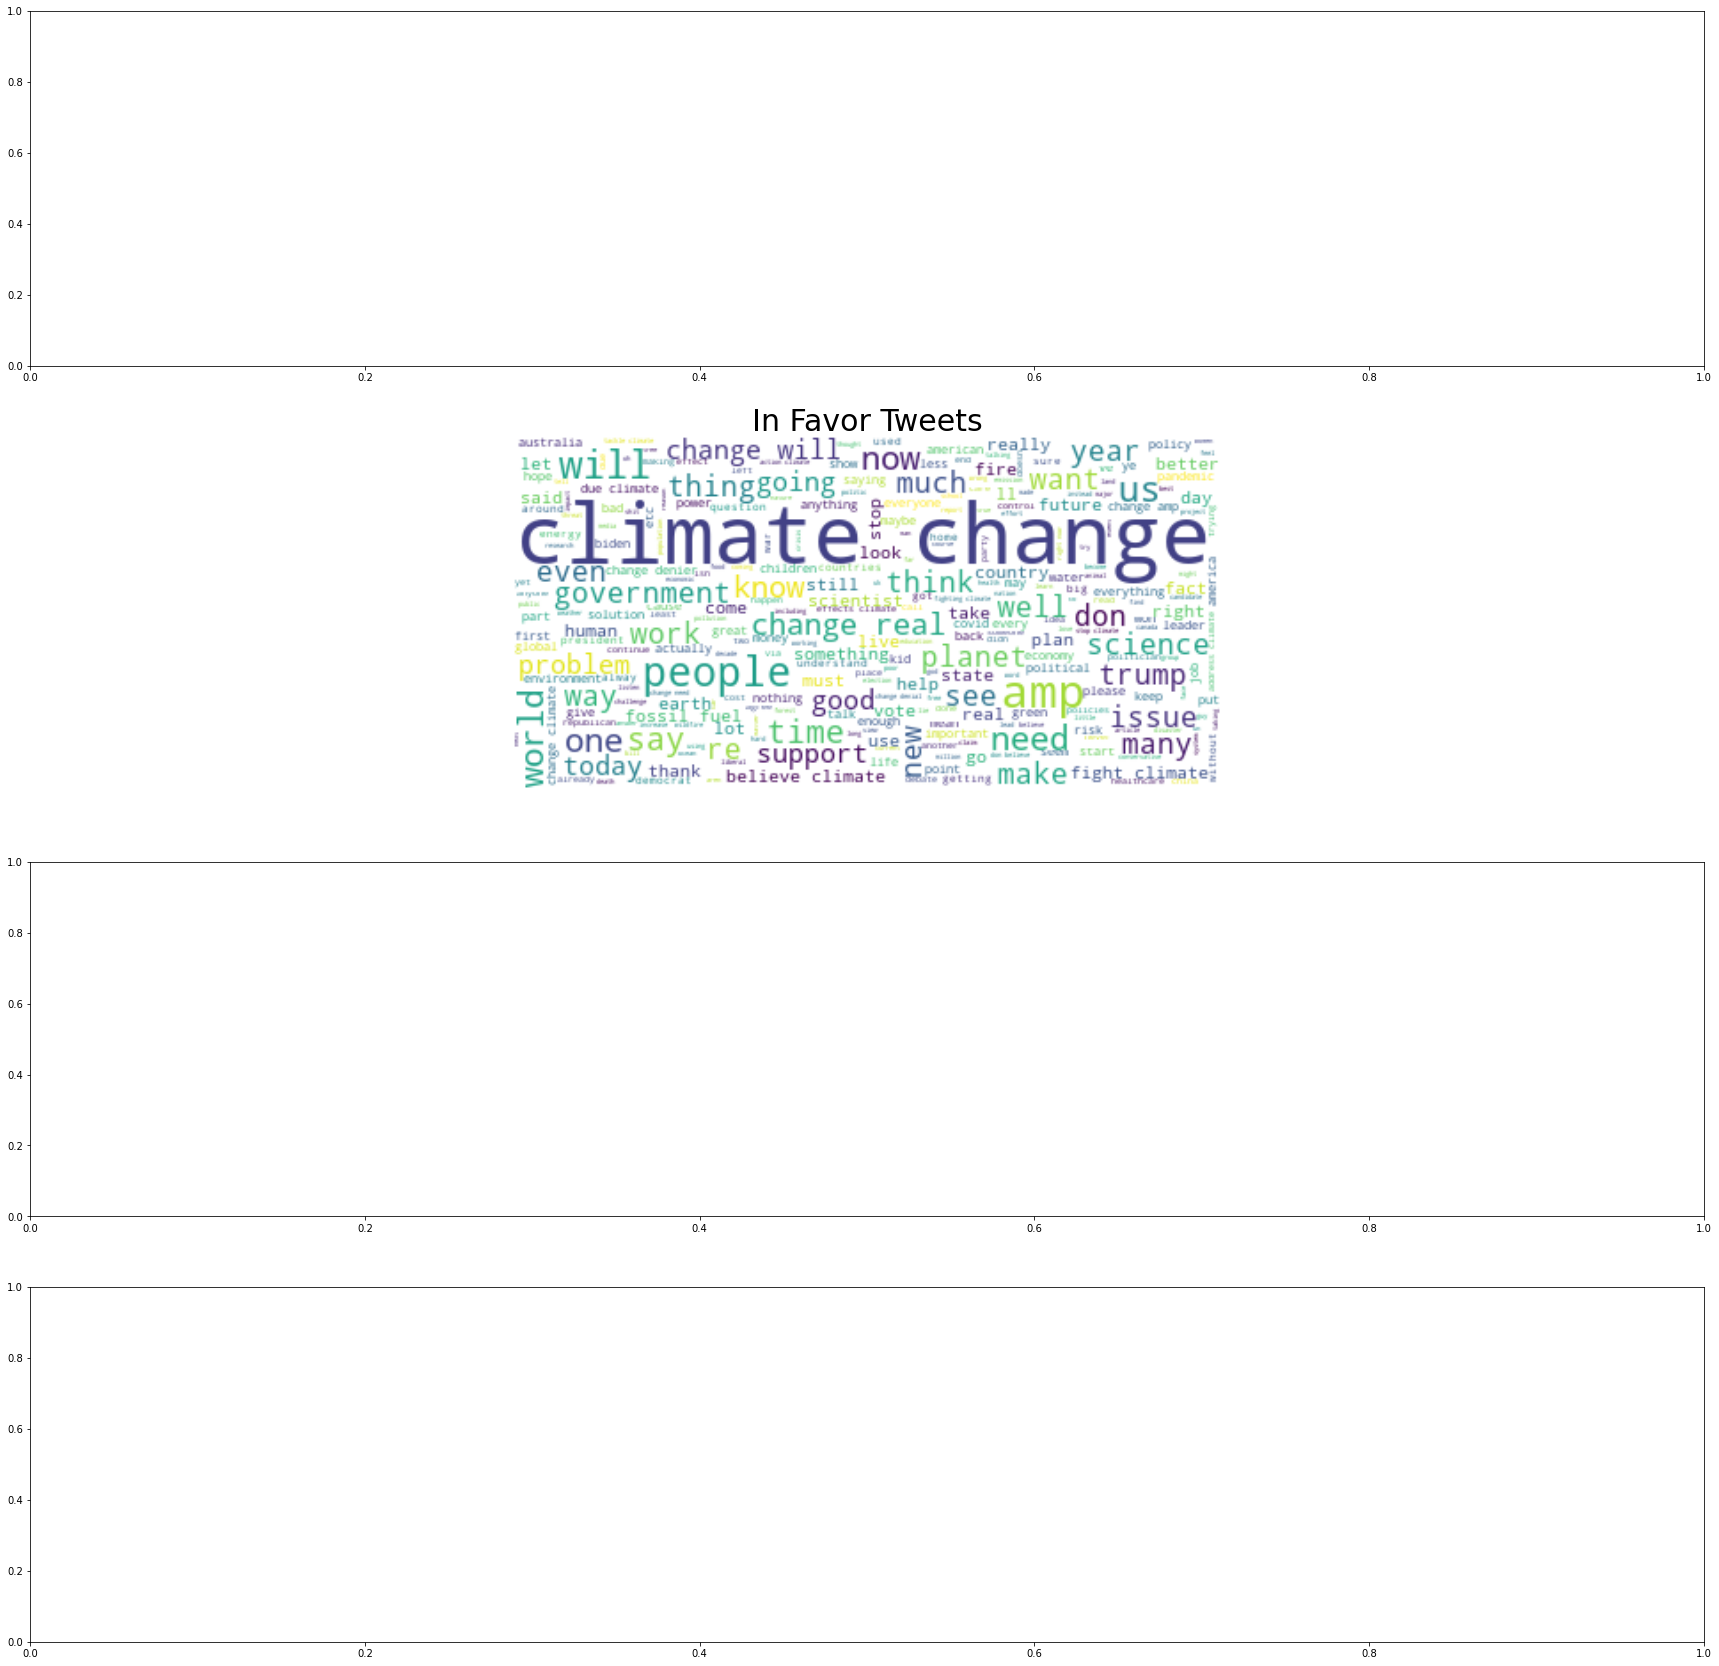

In [ ]:
#understanding drivers for and against through word clouds
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt

# Start with one review:
in_favor = random_unlabeled[random_unlabeled['classes']==1]
against = random_unlabeled[random_unlabeled['classes']==2]

tweet_favor = " ".join(review for review in in_favor.clean_tweets)
tweet_against = " ".join(review for review in against.clean_tweets)

fig, ax = plt.subplots(4, 1, figsize  = (30,30))
#word cloud for in favor tweets
wordcloud_favor = WordCloud(max_font_size=50, max_words=10000, background_color="white").generate(tweet_favor)

# Display the generated image:
ax[1].imshow(wordcloud_favor, interpolation='bilinear')
ax[1].set_title('In Favor Tweets',fontsize=30)
ax[1].axis('off')

#saving as png and downloading
#plt.savefig("favor_tweets.png")
#from google.colab import files
#files.download("favor_tweets.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

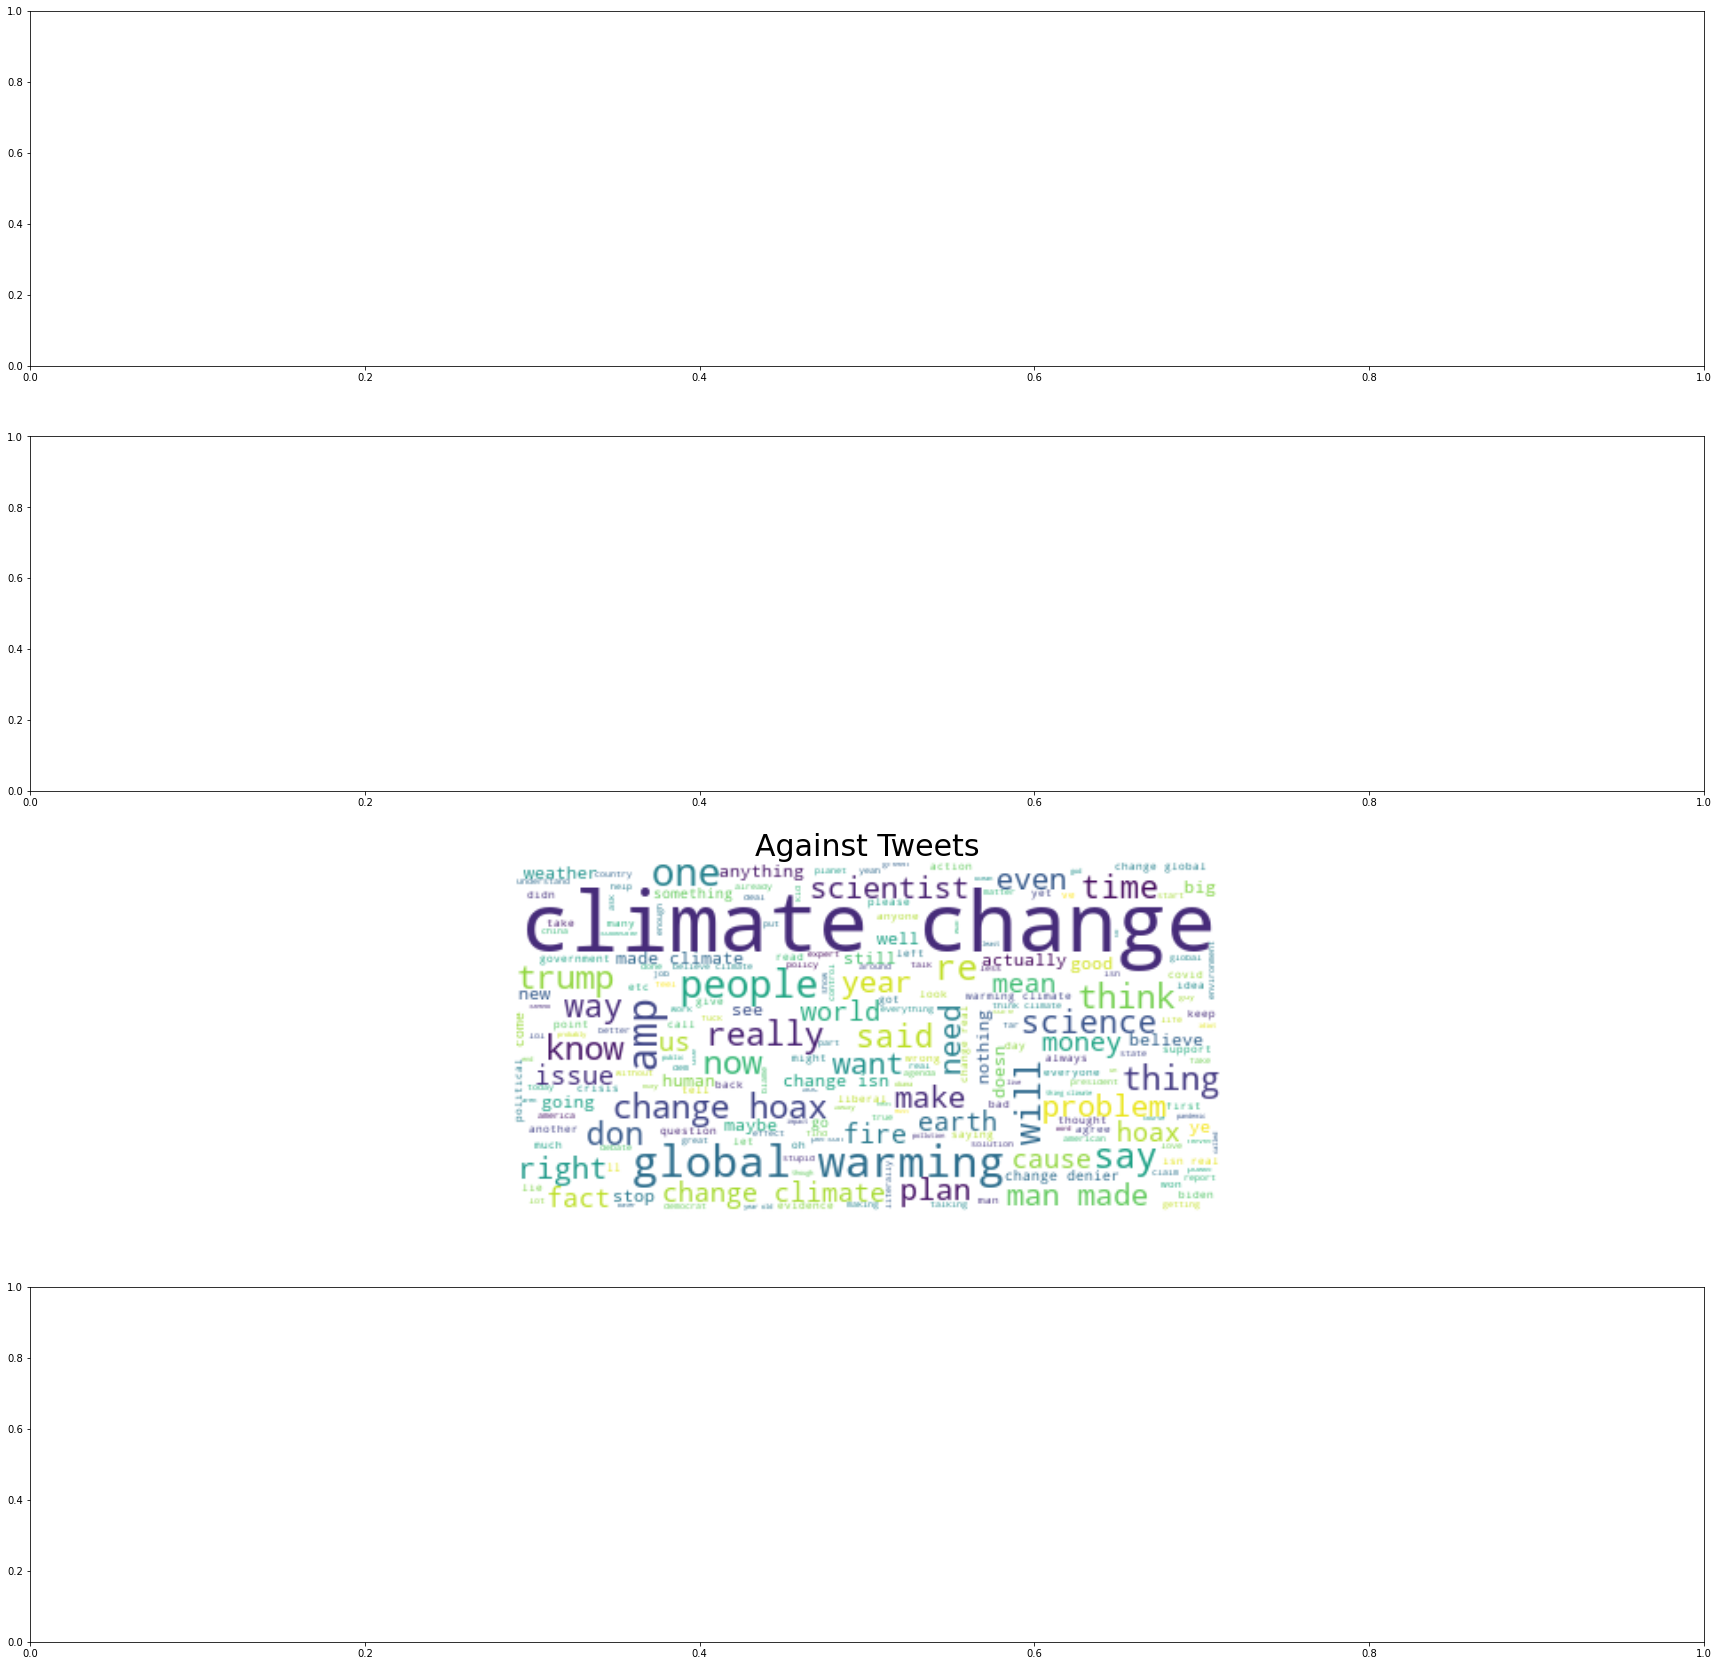

In [ ]:
#wordcloud for against tweets
fig, ax = plt.subplots(4, 1, figsize  = (30,30))
wordcloud_against = WordCloud(max_font_size=50, max_words=10000, background_color="white").generate(tweet_against)
ax[2].imshow(wordcloud_against, interpolation='bilinear')
ax[2].set_title('Against Tweets',fontsize=30)
ax[2].axis('off')

#saving as png and downloading
#plt.savefig("against_tweets.png")
#from google.colab import files
#files.download("against_tweets.png")